In [1]:
import mxnet as mx
import random
import numpy as np
import gym
import time
import logging
import matplotlib.pyplot as plt
from memory import Memory
from mxnet import nd, autograd
from IPython import display
from collections import namedtuple
from model.simple_stack import SimpleStack

/home/seventheli/.local/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while

In [46]:
#Articheture
batch_size = 12
image_size = 256
#Trickes
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 50000
# With Freq of 1/4 step update the Q-network
learning_frequency = 4
# Skip N-1 raw frames between steps
skip_frame = 1
 # Skip N-1 raw frames between skipped frames
internal_skip_frame = 1
# Each state is formed as a concatination N step frames [f(t-4),f(t-3),f(t-2),f(t)]
frame_len = 4
# Update the target network each 10000 steps
Target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.1
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 100000.
# The discount factor
gamma = 0.99
# Start to backpropagated through the network, learning starts
replay_start_size = 5000
# Run uniform policy for first 5 times step of the beginning of the game
no_op_max = 5 / skip_frame
#otimization
num_episode = 10000000  # Number episode to run the algorithm
max_frame = 200000000
# RMSprop learning rate
lr = 0.001
# RMSprop gamma1
gamma1 = 0.95  
# RMSprop gamma2
gamma2 = 0.95
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()  

In [3]:
from gym_minigrid.envs.simple2Dv1 import Simple2Dv1

In [53]:
map_size= 20
agent_view = 5
roads = 1
max_step=50

In [54]:
env_name = "single_blue"  # Set the desired environment
env = Simple2Dv1(map_size, map_size, agent_view=agent_view, roads=roads, max_step=max_step)
# env_name = "AssaultNoFrameskip-v4"  # Set the desired environment
# env = gym.make(env_name)
num_action = env.action_space.n  # Extract the number of available action from the environment setting
manualSeed = 1  # random.randint(1, 10000) # Set the desired seed to reproduce the results
mx.random.seed(manualSeed)
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)

In [6]:
offline_model = SimpleStack(env.action_space.n)
offline_model.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [7]:
online_model = SimpleStack(env.action_space.n)
online_model.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [8]:
trainer = mx.gluon.Trainer(offline_model.collect_params(), 'RMSProp',
                           {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})

In [9]:
def preprocess(raw_frame, current_state=None, initial_state=False):
    raw_frame = nd.array(raw_frame, mx.cpu())
    # raw_frame = nd.reshape(nd.mean(raw_frame, axis=2), shape=(raw_frame.shape[0], raw_frame.shape[1], 1))
    raw_frame = mx.image.imresize(raw_frame, image_size, image_size)
    raw_frame = nd.transpose(raw_frame, (2, 0, 1))
    raw_frame = raw_frame.astype(np.float32) / 255.
    if initial_state:
        state = raw_frame
        for _ in range(frame_len - 1):
            state = nd.concat(state, raw_frame, dim=0)
    else:
        state = mx.nd.concat(current_state[0][3:,:,:], raw_frame, dim = 0)
    return state


def rew_clipper(rew):
    if rew > 0.:
        return 1.
    elif rew < 0.:
        return -1.
    else:
        return 0


def renderimage(next_frame):
    if render_image:
        plt.imshow(next_frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

### Initialize arrays

In [10]:
frame_counter = 0.  # Counts the number of steps so far
annealing_count = 0.  # Counts the number of annealing steps
epis_count = 0.  # Counts the number episodes so far
replay_memory = Memory(replay_buffer_size)  # Initialize the replay buffer
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
average_clipped = 0.
average = 0.

In [11]:
next_frame = env.reset()
state = preprocess(next_frame, initial_state=True)

In [16]:
render_image = False  # Whether to render Frames and show the game

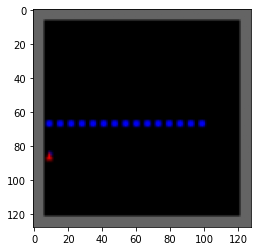

In [73]:
_ = 128
raw_frame = nd.array(env.reset(), mx.cpu())
raw_frame = mx.image.imresize(raw_frame, _, _)
raw_frame = nd.transpose(raw_frame, (2, 0, 1))
raw_frame = raw_frame.astype(np.float32) / 255.
plt.figure(figsize=(4,4))
plt.imshow(nd.transpose(raw_frame, (1, 2, 0)).asnumpy())
plt.show()

### Train the model

In [17]:
while frame_counter < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    state = preprocess(next_frame, initial_state=True)
    t = 0.
    done = False
    while not done:
        previous_state = state
        # show the frame
        renderimage(next_frame)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print('annealing and laerning are started ')
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)
        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.

        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len, image_size, image_size]), ctx), nd.array([env.battery], ctx)]
            action = int(nd.argmax(offline_model(data), axis=1).as_in_context(mx.cpu()).asscalar())
        next_frame_new, rew, done, extra = env.step(action)
        renderimage(next_frame)
        cum_clipped_reward += rew_clipper(rew)
        cum_reward += rew

        # Reward clipping
        # reward = rew_clipper(rew)
        reward = rew
        next_frame = np.maximum(next_frame_new, next_frame)
        state = preprocess(next_frame, state)
        replay_memory.push((previous_state * 255.).astype('uint8'), action, (state * 255.).astype('uint8'), reward,done, extra)
        # Train
        if frame_counter > replay_start_size:
            if frame_counter % learning_frequency == 0:
                batch = replay_memory.sample(batch_size, ctx)
                batch_state = batch.state.astype('float32') / 255.
                batch_state_next = batch.next_state.astype('float32') / 255.
                batch_reward = batch.reward
                batch_action = batch.action
                batch_done = batch.done
                batch_battery = batch.battery
                with autograd.record():
                    argmax_Q = nd.argmax(offline_model([batch_state_next, batch_battery]), axis=1).astype('uint8')
                    Q_sp = nd.pick(online_model([batch_state_next, batch_battery]), argmax_Q, 1)
                    Q_sp = Q_sp * (nd.ones(batch_size, ctx=ctx) - batch_done)
                    Q_s_array = offline_model([batch_state, batch_battery])
                    Q_s = nd.pick(Q_s_array, batch_action, 1)
                    loss = nd.mean(loss_f(Q_s, (batch_reward + gamma * Q_sp)))
                loss.backward()
                trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter > replay_start_size:
            if frame_counter % Target_update == 0:
                check_point = frame_counter / (Target_update * 100)
                fdqn = './data/model_%s_%d' % (env_name, int(check_point))
                offline_model.save_parameters(fdqn)
                online_model.load_parameters(fdqn, ctx)
                fnam = './data/clippted_rew_DDQN_%s' % (env_name)
                np.save(fnam, tot_clipped_reward)
                fnam = './data/tot_rew_DDQN_%s' % (env_name)
                np.save(fnam, tot_reward)
                fnam = './data/frame_count_DDQN_%s' % (env_name)
                np.save(fnam, frame_count_record)

        if done:
            if epis_count % 100 == 0.:
                print('epis[%d],eps[%f],durat[%d],fnum=%d, cum_cl_rew = %f, cum_rew = %f,tot_cl = %f , tot = %f'
                      % (epis_count, eps, t, frame_counter, cum_clipped_reward, cum_reward, average_clipped,average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record, frame_counter)
    if epis_count > 100.:
        average_clipped = np.mean(tot_clipped_reward[int(epis_count) - 1 - 100:int(epis_count) - 1])
        average = np.mean(tot_reward[int(epis_count) - 1 - 100:int(epis_count) - 1])
from tempfile import TemporaryFile

outfile = TemporaryFile()
outfile_clip = TemporaryFile()
np.save(outfile, moving_average)
np.save(outfile_clip, average_clipped)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

### Plot the overall performace

Running after 37172 number of episodes


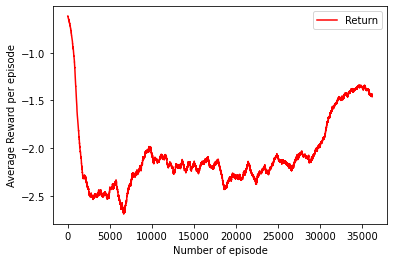

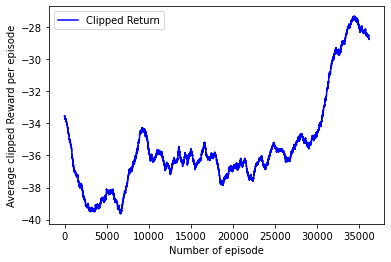

In [14]:
num_epis_count = epis_count - 0
bandwidth = 1000  # Moving average bandwidth 
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN_Clipped.png')